# Import and Cleaning

In [125]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [126]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [127]:
data = pd.read_csv("../data/pre_processed_pdb_mordred_2d.csv")
data.head()

/tmp/ipykernel_1762445/1940003184.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/pre_processed_pdb_mordred_2d.csv")


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0,1.0


In [128]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [129]:
X = data.iloc[:, 14:-1]
X.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,nSpiro,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,2.449490,0.0,3.000000e+00,1.732051,0.866025,1.931852,5.583629,0.803548,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0
1,3.047207,0.0,1.110223e-16,1.847759,1.045250,2.130986,8.629874,1.462083,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0
2,3.047207,0.0,1.110223e-16,1.847759,1.045250,2.130986,8.629874,1.462083,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0
3,2.121320,0.0,1.000000e+00,1.618034,1.118034,1.946498,5.891993,0.857304,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0
4,2.449490,0.0,1.110223e-16,1.732051,0.866025,1.931852,5.583629,0.803548,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0


In [130]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [131]:
DESCRIPTOR_TYPE = "mordred"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [132]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.747161,-0.479647,-0.518778,-0.122937,-0.170939,-0.591246,-0.019183,-0.918446,-0.603209,...,0.729432,1.248557,1.196812,0.640386,1.499423,0.180397,-1.703257,-1.406161,-0.959561,0.644125
1,1.0,-0.892816,0.572983,-0.518778,-1.325669,-1.206940,-1.338620,-0.019183,-0.727966,-1.455680,...,0.653917,-0.835196,0.254794,-1.335757,0.094096,1.257407,0.081764,-1.406161,-0.959561,0.644125
2,1.0,-0.892907,-0.479647,-0.518778,-0.249045,-0.436497,-1.050824,-0.019183,-1.118767,-0.176973,...,1.029268,-0.438332,2.118940,0.249781,2.352375,-2.058032,-1.703257,-1.406161,-1.393315,0.644125
3,1.0,-0.486730,-0.479647,-0.518778,0.031003,-0.293828,-0.442330,-0.019183,-0.445189,-0.603209,...,1.250737,-0.080792,0.961981,-0.367263,0.598547,0.127250,0.872193,0.071842,0.775454,-1.055445
4,1.0,-0.506477,-0.479647,-0.518778,0.624042,0.512896,-0.182120,-0.019183,-0.618327,-0.176973,...,0.827757,0.397068,0.297369,0.358597,1.248796,0.802388,-0.157987,-1.406161,0.775454,1.102438


In [133]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.949818,-0.499348,0.047152,-1.125587,-0.622870,-1.188369,-0.032601,-1.110593,-0.570480,...,-0.371717,0.996703,0.957105,0.720049,0.996364,-1.919591,-1.614426,-1.420145,0.781951,-1.099043
1,1.0,-0.170490,-0.499348,-0.591418,1.064460,-0.617222,-0.141302,-0.032601,-0.011500,0.253305,...,1.201378,0.878208,1.145377,1.114929,0.025990,1.751536,1.353676,0.912194,0.781951,0.589079
2,1.0,0.155114,1.545500,-0.591418,0.330421,0.547297,0.542395,-0.032601,0.073690,0.939792,...,0.295183,-0.396453,-0.834452,-0.673114,-0.422390,0.066103,0.491843,0.325428,-0.282388,0.589079
3,1.0,-0.785319,-0.499348,0.047152,-1.069821,-1.960134,-0.820885,-0.032601,-0.927184,-0.570480,...,0.664224,1.681691,0.366668,0.235019,3.355795,-0.649452,-1.614426,-1.420145,0.781951,-1.099043
4,1.0,-0.394264,0.523076,0.047152,-0.371701,-0.839898,0.065391,-0.032601,-0.466857,0.253305,...,0.432500,1.186564,-0.404320,1.958826,0.220964,0.432518,0.942693,0.867020,-0.434437,-1.099043


# Logistic Regression

## Model Constant Variables

In [134]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [135]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [136]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 15:05


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 15:05
Tempo de execução:  0.2 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [137]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.677544,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [138]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

# removing const column
x_train_scaled_logit = x_train_scaled.drop(["const"], axis=1)
x_test_scaled_logit = x_test_scaled.drop(["const"], axis=1)

Here, we encounter a problem. Even though the descriptors with high correlation were already removed, when the dataset was divided into training and test sets, some correlation was artificially created between some descriptors, and that breaks the logistic regressions. Because of that, only for logistic regression, some descriptors will be removed. To do this, the correlation matrix will be calculated in the training dataset, and the descriptors to be removed will be selected. Than, they will be removed from both the training and the test datasets.

In [139]:
def remove_high_corr_training_test(df_training, df_test, corr_threshold):
  '''DataFrame, float --> DataFrame

  -----------------------------------------------------------------------------

  This fuction recieved a df and a threshold value for correlation. It will than,
  for each pair or features with correlation above the threshold, select only one.
  It will than return the df without those variables.'''

  #Correlation matrix
  corr_matrix = df_training.corr().abs()

  #Selecting upper triangle from correlation matrix
  corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

  #Selecting variables to be removed
  remove = []

  for col in corr_matrix.columns:
    if any(corr_matrix[col] > corr_threshold):
      remove.append(col)  
  
  print(f'Number of features removed: {len(remove)}')

  return df_training.drop(remove, axis = 1), df_test.drop(remove, axis = 1)

In [140]:
x_train_scaled_logit, x_test_scaled_logit = remove_high_corr_training_test(x_train_scaled_logit, x_test_scaled_logit, 0.8)

Number of features removed: 171


In [141]:
x_train_scaled.shape

(2842, 545)

In [142]:
x_train_scaled_logit.shape

(2842, 373)

In [145]:
a = sm.GLM(y_train, x_train_scaled, family=sm.families.Binomial()).fit()

/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [150]:
lasso_model = sm.GLM(y_train, x_train_scaled, family=sm.families.Gaussian(), alpha=0.1, reg_kwds={'type': 'elastic_net', 'alpha': 1})
lasso_results = lasso_model.fit()

/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['alpha', 'reg_kwds']
  warnings.warn(msg, ValueWarning)


In [153]:
lasso_model = sm.Logit(y_train, x_train_scaled).fit_regularized(method='l2', alpha=0.1)

ValueError: `method` = l2 is not supported, use either "l1" or "l1_cvxopt_cp"

In [161]:
try:
    logit_model = sm.Logit(y_train, x_train_scaled)
    result = logit_model.fit(method='bfgs', maxiter=10000)  # Specify 'bfgs' solver
    # Print summary of the model
    print(result.summary())

    # Extract p-values for each descriptor
    p_values = result.pvalues
    print("\nP-values:")
    print(p_values)
except Exception as e:
    print("Error:", e)

Optimization terminated successfully.
         Current function value: 0.319584
         Iterations: 2265
         Function evaluations: 2267
         Gradient evaluations: 2267


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:           fda_approved   No. Observations:                 2842
Model:                          Logit   Df Residuals:                     2312
Method:                           MLE   Df Model:                          529
Date:                Fri, 10 May 2024   Pseudo R-squ.:                  0.5389
Time:                        11:36:26   Log-Likelihood:                -908.26
converged:                       True   LL-Null:                       -1969.9
Covariance Type:            nonrobust   LLR p-value:                2.222e-189
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1858        nan        nan        nan         nan         nan
ABC              -49.6609        nan        nan        nan         nan         nan
nAcid             -0.1601        nan

In [162]:
np.diag(result.cov_params())

ValueError: need covariance of parameters for computing (unnormalized) covariances

In [159]:
x_train_scaled

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.747161,-0.479647,-0.518778,-0.122937,-0.170939,-0.591246,-0.019183,-0.918446,-0.603209,...,0.729432,1.248557,1.196812,0.640386,1.499423,0.180397,-1.703257,-1.406161,-0.959561,0.644125
1,1.0,-0.892816,0.572983,-0.518778,-1.325669,-1.206940,-1.338620,-0.019183,-0.727966,-1.455680,...,0.653917,-0.835196,0.254794,-1.335757,0.094096,1.257407,0.081764,-1.406161,-0.959561,0.644125
2,1.0,-0.892907,-0.479647,-0.518778,-0.249045,-0.436497,-1.050824,-0.019183,-1.118767,-0.176973,...,1.029268,-0.438332,2.118940,0.249781,2.352375,-2.058032,-1.703257,-1.406161,-1.393315,0.644125
3,1.0,-0.486730,-0.479647,-0.518778,0.031003,-0.293828,-0.442330,-0.019183,-0.445189,-0.603209,...,1.250737,-0.080792,0.961981,-0.367263,0.598547,0.127250,0.872193,0.071842,0.775454,-1.055445
4,1.0,-0.506477,-0.479647,-0.518778,0.624042,0.512896,-0.182120,-0.019183,-0.618327,-0.176973,...,0.827757,0.397068,0.297369,0.358597,1.248796,0.802388,-0.157987,-1.406161,0.775454,1.102438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,1.0,-0.417987,-0.479647,-0.518778,-0.710977,-0.308016,0.018985,-0.019183,-0.478757,0.249262,...,-0.594844,-0.389047,2.336066,0.492172,-0.850898,1.099529,0.770531,0.420436,0.775454,-1.055445
2838,1.0,-0.341074,-0.479647,0.159716,0.424679,0.525006,-0.117343,-0.019183,-0.359675,0.249262,...,-1.295985,0.064326,0.175233,0.460919,0.815408,1.021024,0.058893,-0.420826,0.775454,-1.055445
2839,1.0,0.063459,-0.479647,-0.518778,1.112306,0.651423,-0.061204,-0.019174,1.695868,-1.455680,...,-0.279392,0.174918,-0.324270,0.348470,-0.014285,0.210767,0.314417,-0.124107,0.775454,0.644125
2840,1.0,-0.623975,-0.479647,-0.518778,-0.170272,-0.612717,-0.472495,-0.019183,-0.753385,0.249262,...,1.214880,0.578730,-0.764951,3.138752,-0.315063,-0.097218,3.854293,-1.406161,0.775454,-1.055445


In [163]:
# calculatin model
log_reg = sm.Logit(y_train, x_train_scaled).fit()
log_reg_results = log_reg.summary()

/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
log_reg_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           fda_approved   No. Observations:                 2842
Model:                          Logit   Df Residuals:                     2820
Method:                           MLE   Df Model:                           21
Date:                Thu, 09 May 2024   Pseudo R-squ.:                 0.05562
Time:                        11:42:24   Log-Likelihood:                -1860.4
converged:                      False   LL-Null:                       -1969.9
Covariance Type:            nonrobust   LLR p-value:                 6.032e-35
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ABC           -0.5024        nan        nan        nan         nan         nan
VR1_A         -0.0645        nan        nan        nan         nan         nan
nB            -0.0807        nan        nan        nan         nan         nan
nS            -0.0010        nan        nan        nan         nan         nan
nF             0.1021        nan        nan        nan         nan         nan
nCl            0.1039        nan        nan        nan         nan         nan
nBr           -0.1294        nan        nan        nan         nan         nan
nI            -0.0183        nan        nan        nan         nan         nan
nBondsT       -0.0267        nan        nan        nan         nan         nan
Xch-3d         0.0567        nan        nan        nan         nan         nan
NdCH2          0.1731        nan        nan        nan         nan         nan
NddC          -0.1528        nan        nan        nan         nan         nan
NdssS          0.0153        nan        nan        nan         nan         nan
NsssdAs        0.1311        nan        nan        nan         nan         nan
NssSe               0        nan        nan        nan         nan         nan
SssSe               0        nan        nan        nan         nan         nan
n7Ring         0.2043        nan        nan        nan         nan         nan
n8Ring         0.4660        nan        nan        nan         nan         nan
n9Ring         0.1779        nan        nan        nan         nan         nan
n10Ring        0.0886        nan        nan        nan         nan         nan
n4aRing       -0.1425        nan        nan        nan         nan         nan
n7aRing        0.0901        nan        nan        nan         nan         nan
n12FRing       0.0474        nan        nan        nan         nan         nan
n8FaRing      -0.1569        nan        nan        nan         nan         nan
==============================================================================
"""

## Get Training Error and AUC

In [ ]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=log_reg, 
    x=x_train_scaled,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.1717
Training AUC: 0.8283


## Make Predictions

In [ ]:
# the log_reg algorithm predicts as probabilities
y_predict_lr_prob = log_reg.predict(x_test_scaled)

In [ ]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

## Test Error

In [ ]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.2247


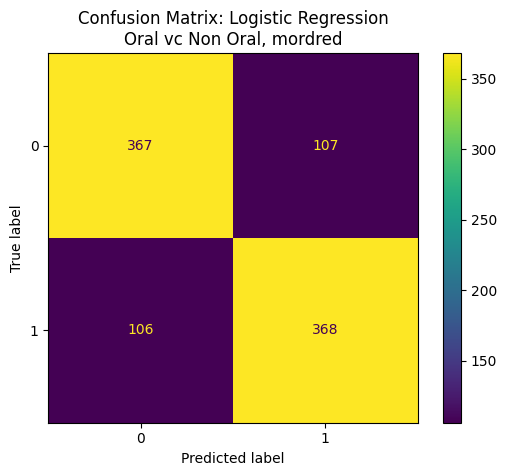

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

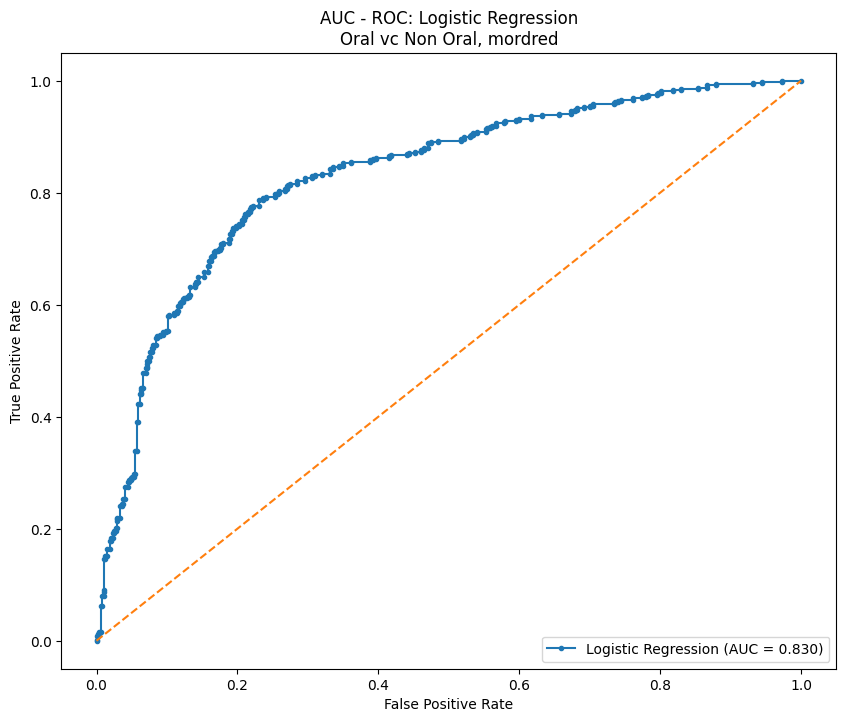

In [ ]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [ ]:
# converting results summary to pandas dataframe
results_log_reg_html = log_reg_results.tables[1].as_html()
results_log_reg_df = pd.read_html(results_log_reg_html, header=0, index_col=0)[0]
print(results_log_reg_df.shape)
results_log_reg_df.head()

(545, 6)


,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0173,NaN,NaN,NaN,NaN,NaN
ABC,-0.0537,NaN,NaN,NaN,NaN,NaN
nAcid,-0.1143,NaN,NaN,NaN,NaN,NaN
nBase,0.8988,NaN,NaN,NaN,NaN,NaN
SpMax_A,0.3630,NaN,NaN,NaN,NaN,NaN


In [ ]:
important_features_lr = results_log_reg_df[results_log_reg_df["P>|z|"] < 0.05]
print(important_features_lr.shape)
important_features_lr

(0, 6)


,coef,std err,z,P>|z|,[0.025,0.975]


## Saving Results

In [ ]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.17171,0.224684,0.82829,0.829857


In [ ]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [ ]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [ ]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [ ]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 16:04
Finished Grid Search for Decision Tree: 16:50
Tempo de execução:  46.0 minutos


In [ ]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.744382,"{'ccp_alpha': 0, 'criterion': 'log_loss', 'max..."


## Fitting Tree

In [ ]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0, 'criterion': 'log_loss', 'max_depth': 5}

In [ ]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2576
Training AUC: 0.7424


## Make Predictions

In [ ]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.2816


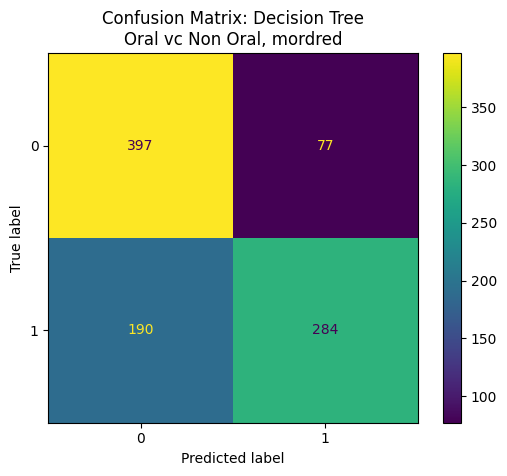

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

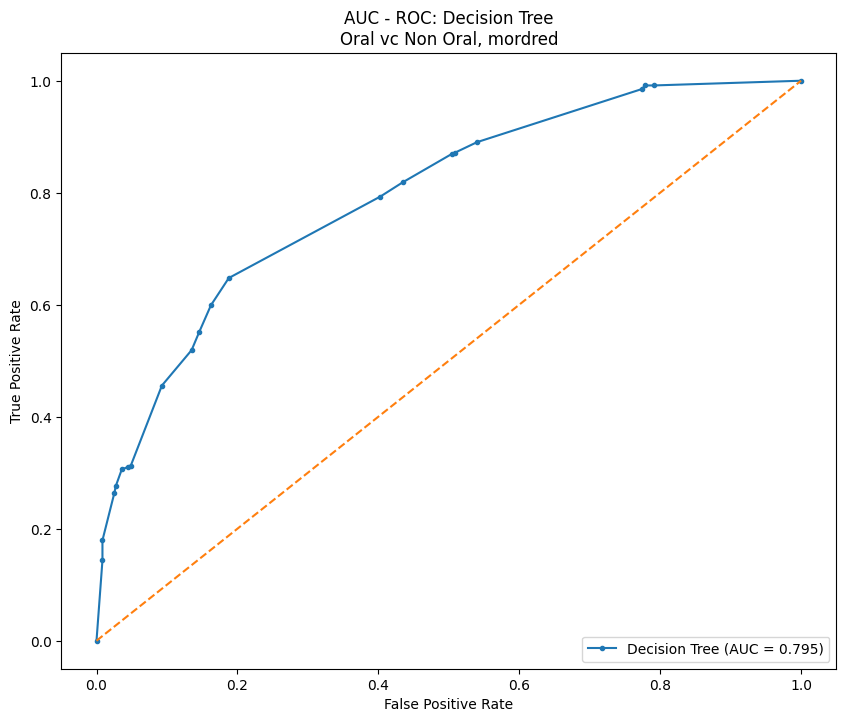

In [ ]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

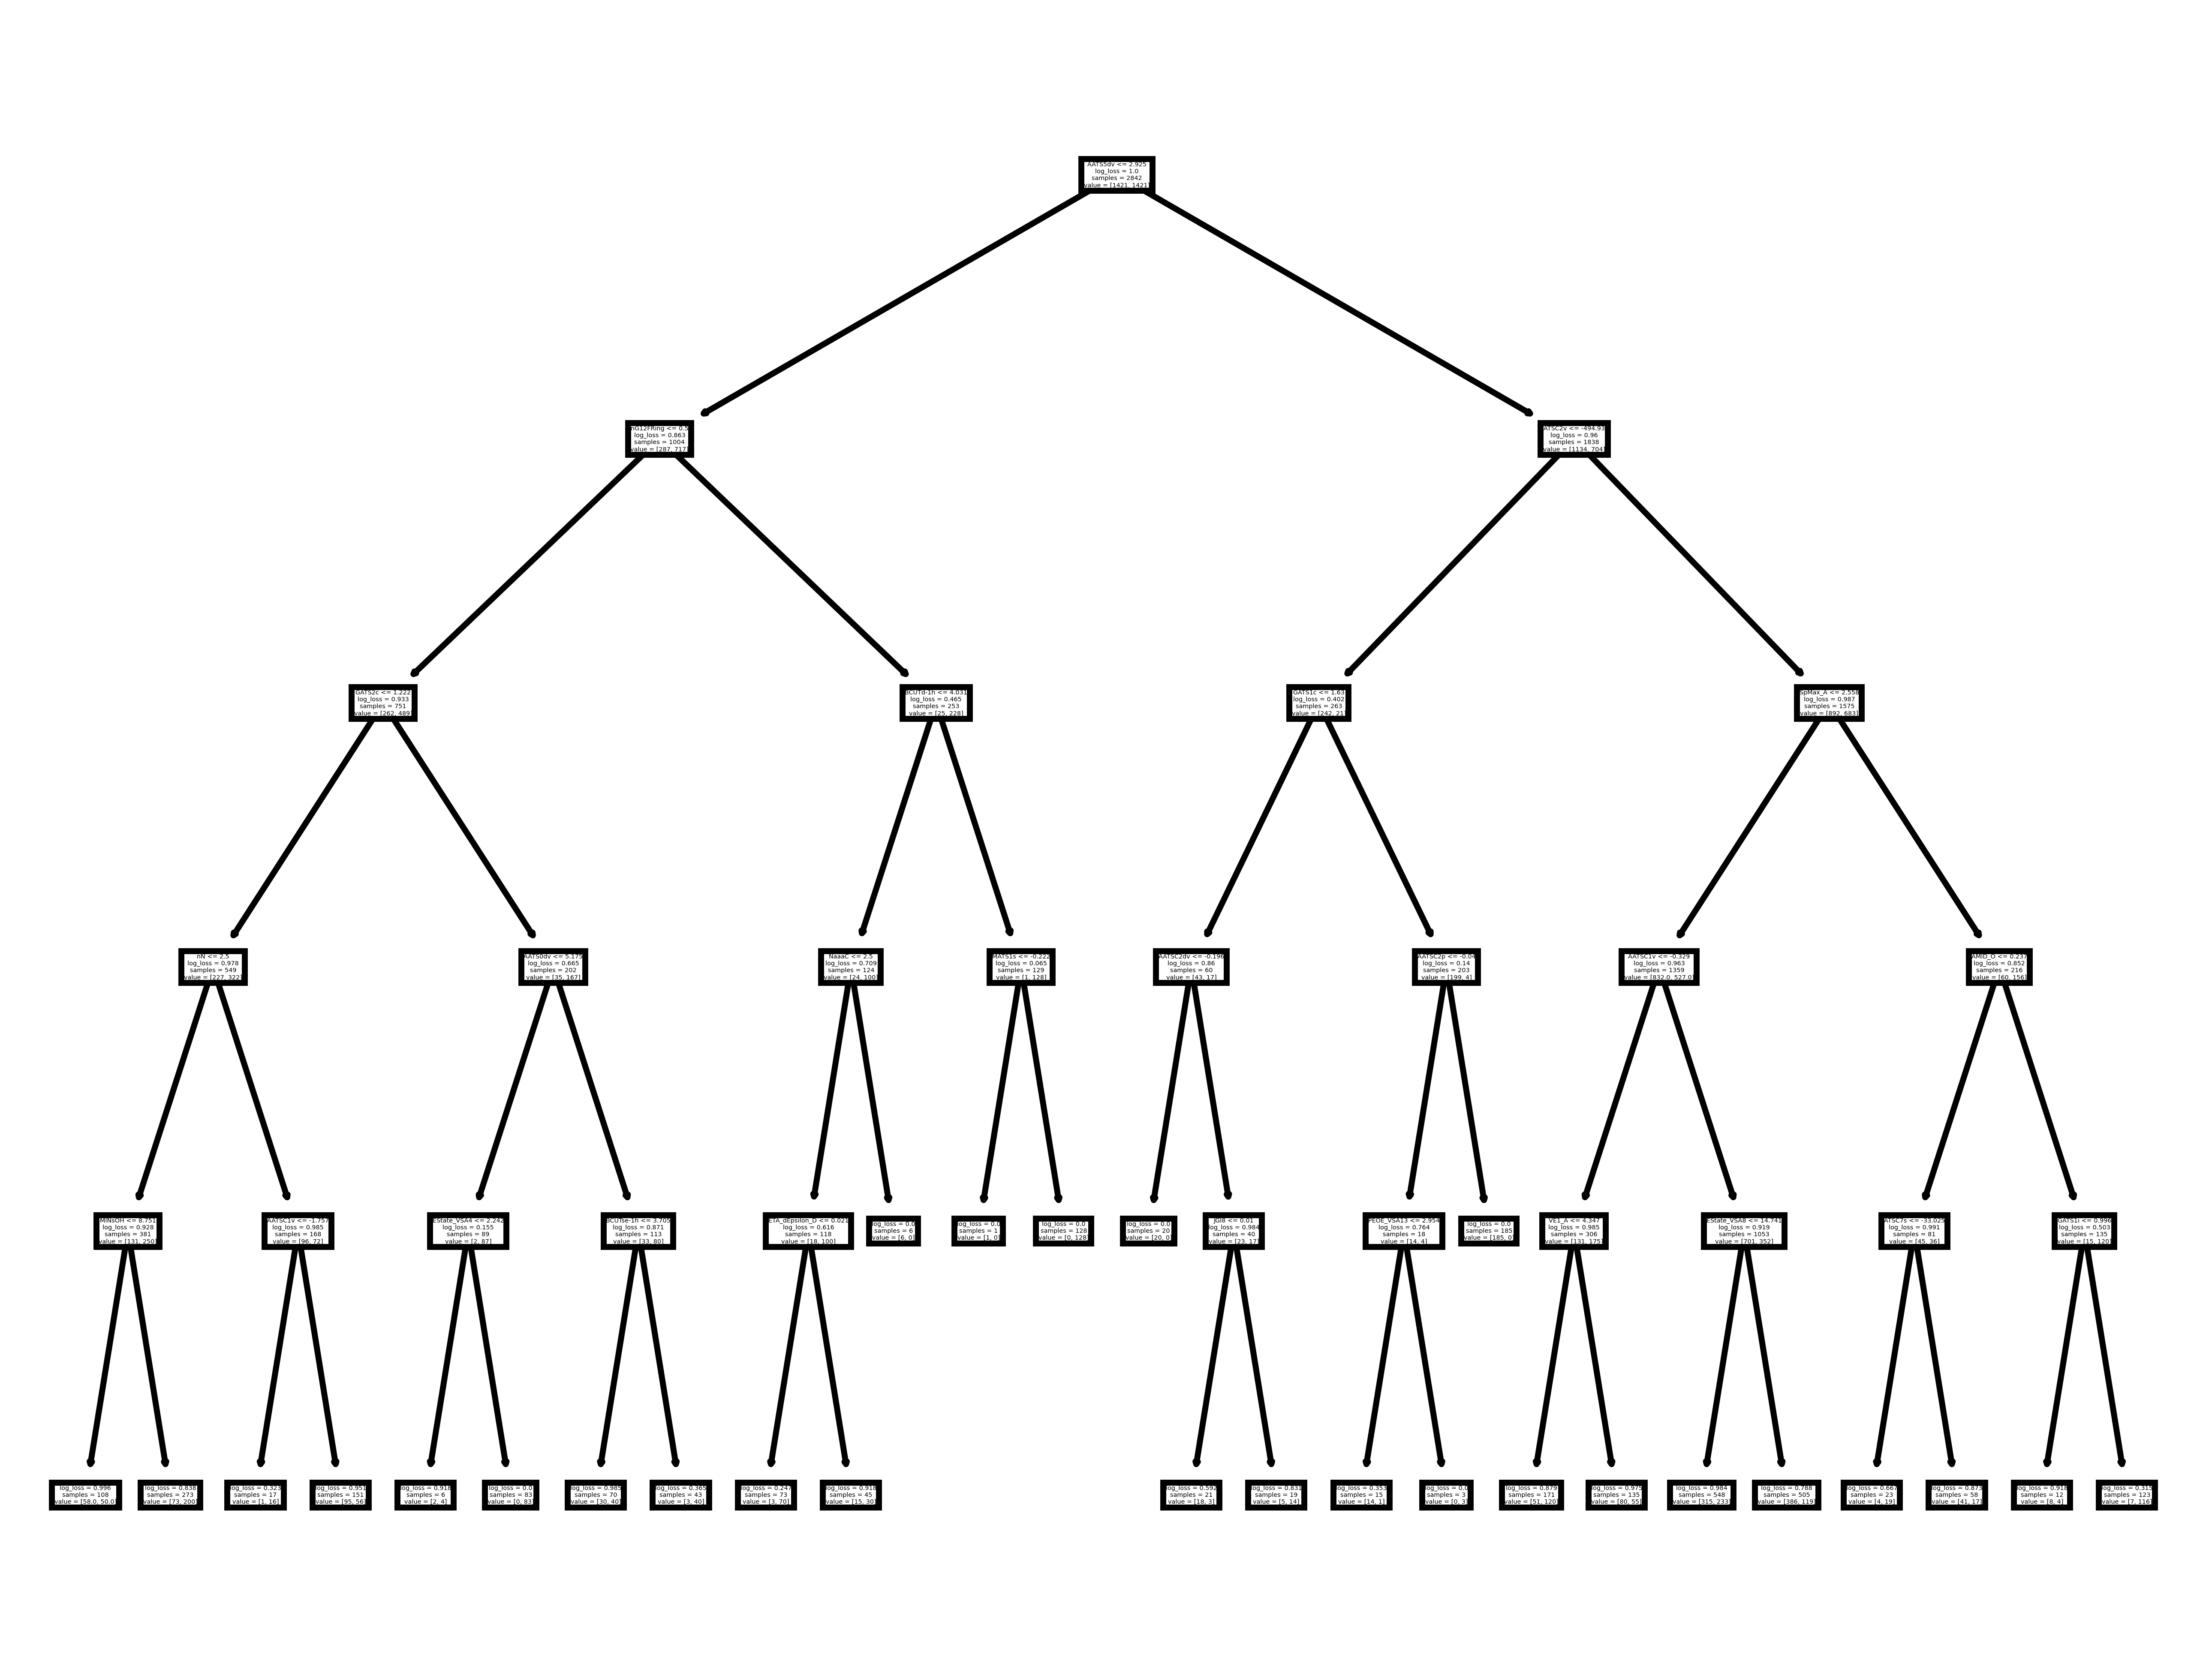

In [ ]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

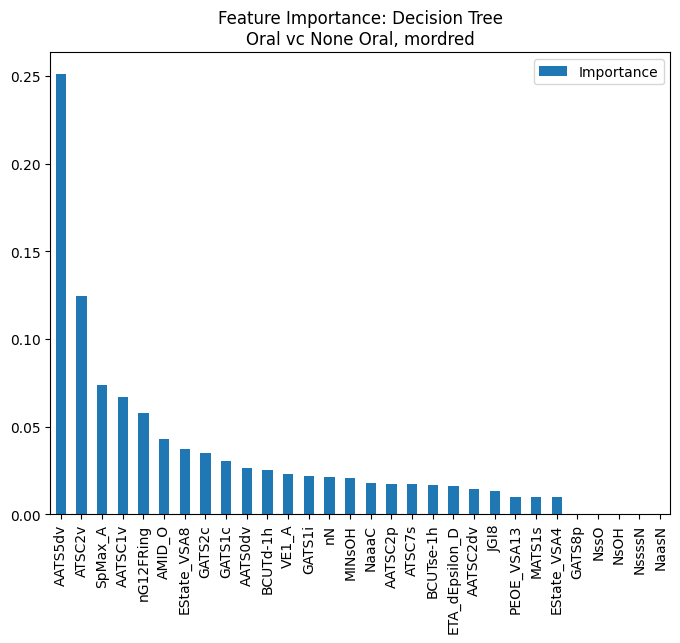

In [ ]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [ ]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
EState_VSA4,0.009887
MATS1s,0.010071
PEOE_VSA13,0.010079
JGI8,0.013261
AATSC2dv,0.014601
ETA_dEpsilon_D,0.015892
BCUTse-1h,0.016447
ATSC7s,0.017081
AATSC2p,0.017426
NaaaC,0.018104


## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.171710,0.224684,0.828290,0.829857
1,Decision Tree,0.744382,0.257565,0.281646,0.742435,0.795125


In [ ]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [ ]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [ ]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0.1, 0.5]
        }
    }
}

In [ ]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 16:50
Finished Grid Search for Random Forest: 19:30
Tempo de execução:  160.1 minutos


In [ ]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.5,"{'ccp_alpha': 0.1, 'max_depth': 10, 'max_featu..."


## Fitting Model

In [ ]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0.1,
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [ ]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.5000
Training AUC: 0.5000


## Make Predictions

In [ ]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.5000


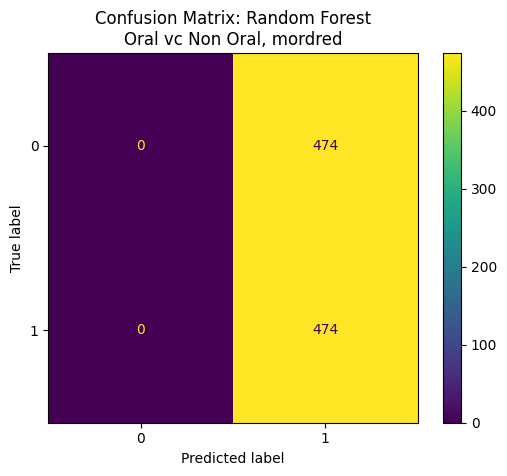

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

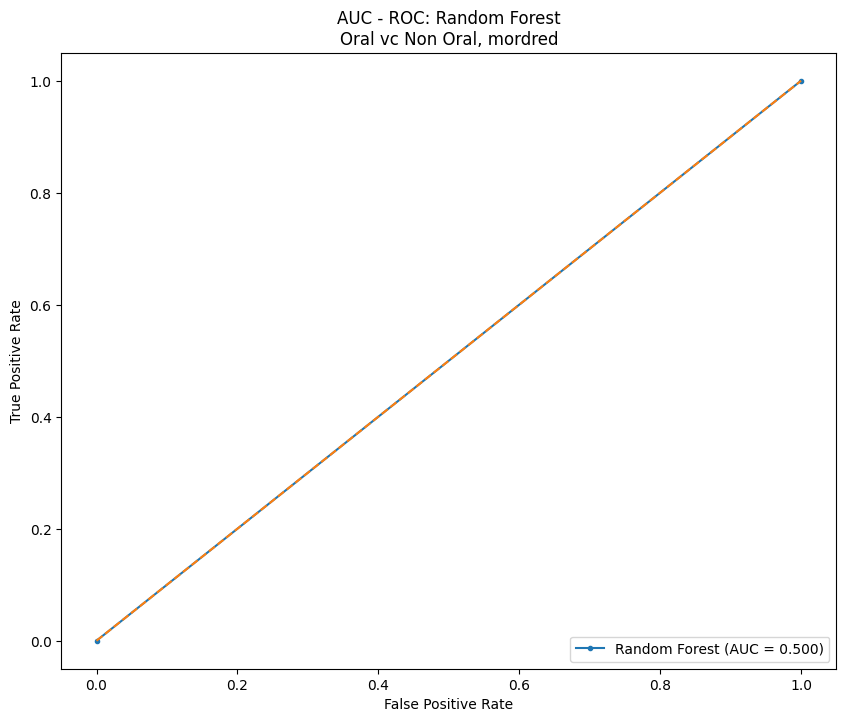

In [ ]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

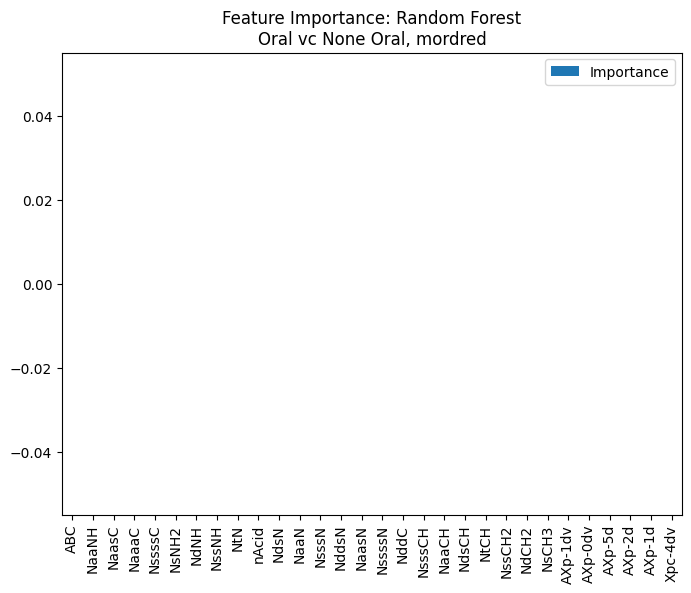

In [ ]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [ ]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance


## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.171710,0.224684,0.828290,0.829857
1,Decision Tree,0.744382,0.257565,0.281646,0.742435,0.795125
2,Random Forest,0.500000,0.500000,0.500000,0.500000,0.500000


In [ ]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [ ]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [ ]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [ ]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 19:30
Finished Grid Search for Boosting: 04:07
Tempo de execução:  516.2 minutos


In [ ]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.805155,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [ ]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [ ]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0021
Training AUC: 0.9979


## Make Prediction

In [ ]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.2511


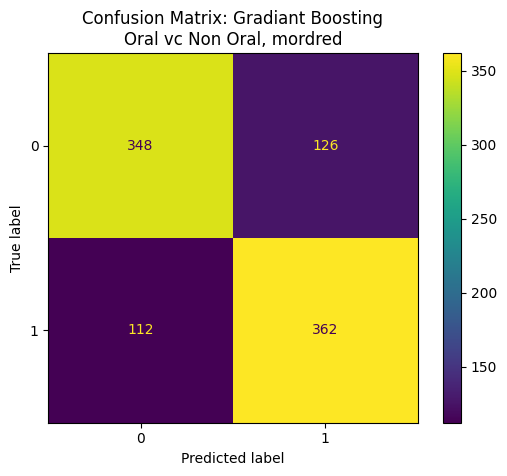

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

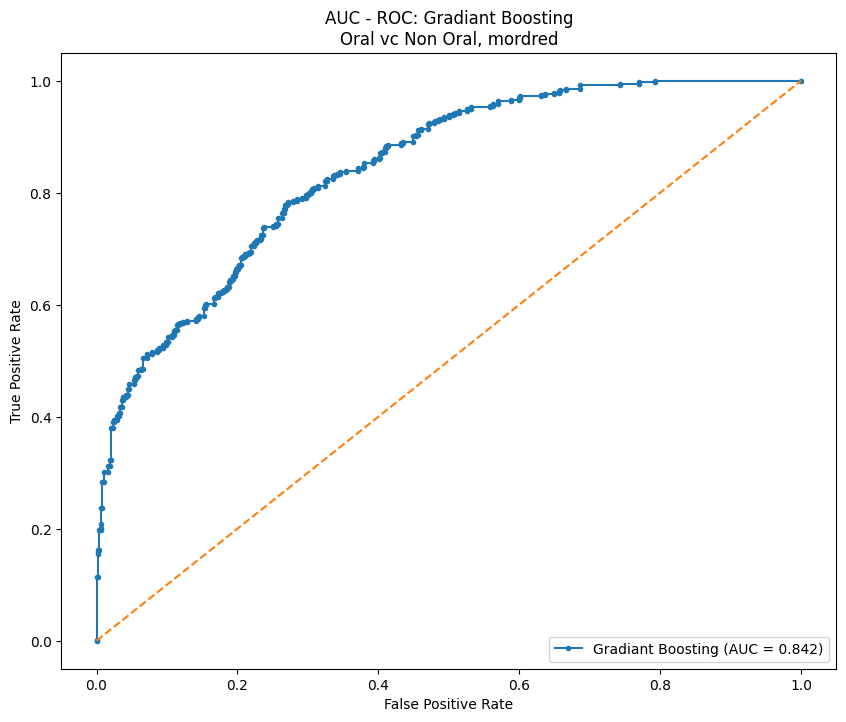

In [ ]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

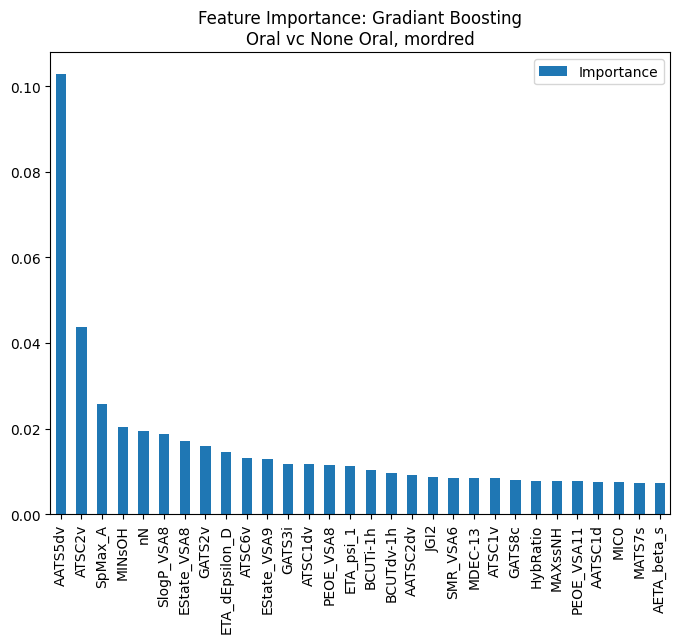

In [ ]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [ ]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
nI,2.222968e-23
n6FRing,7.912981e-21
nB,1.036432e-19
NssssN,4.460447e-19
nP,1.360833e-18
...,...
nN,1.935352e-02
MINsOH,2.030270e-02
SpMax_A,2.586909e-02
ATSC2v,4.366713e-02


## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.171710,0.224684,0.828290,0.829857
1,Decision Tree,0.744382,0.257565,0.281646,0.742435,0.795125
2,Random Forest,0.500000,0.500000,0.500000,0.500000,0.500000
3,Gradiant Boosting,0.805155,0.002111,0.251055,0.997889,0.842386


In [ ]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [ ]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [ ]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [ ]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20] #L
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [ ]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 04:17
Finished Grid Search for BART: 10:38
Tempo de execução:  381.3 minutos


In [ ]:
gs_result_bart

,model,best_score,best_params
0,BART,0.73815,"{'burnin': 10, 'max_stages': 500, 'num_trees':..."


# Fitting Model

In [ ]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 10, 'max_stages': 500, 'num_trees': 500}

In [ ]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=10, max_stages=500, num_trees=500)

## Get Training Error and AUC

In [ ]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.2072
Training AUC: 0.7928


## Make Prediction

In [ ]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [ ]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [ ]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.2384


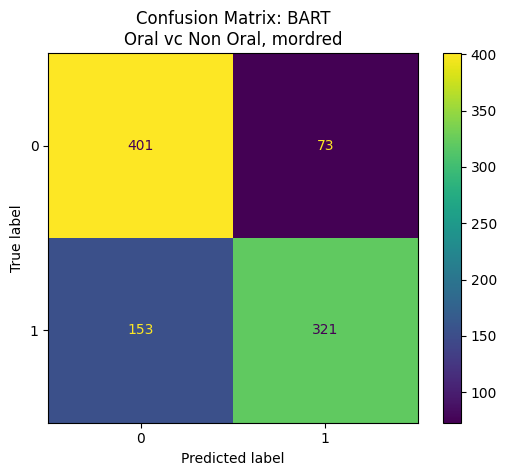

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

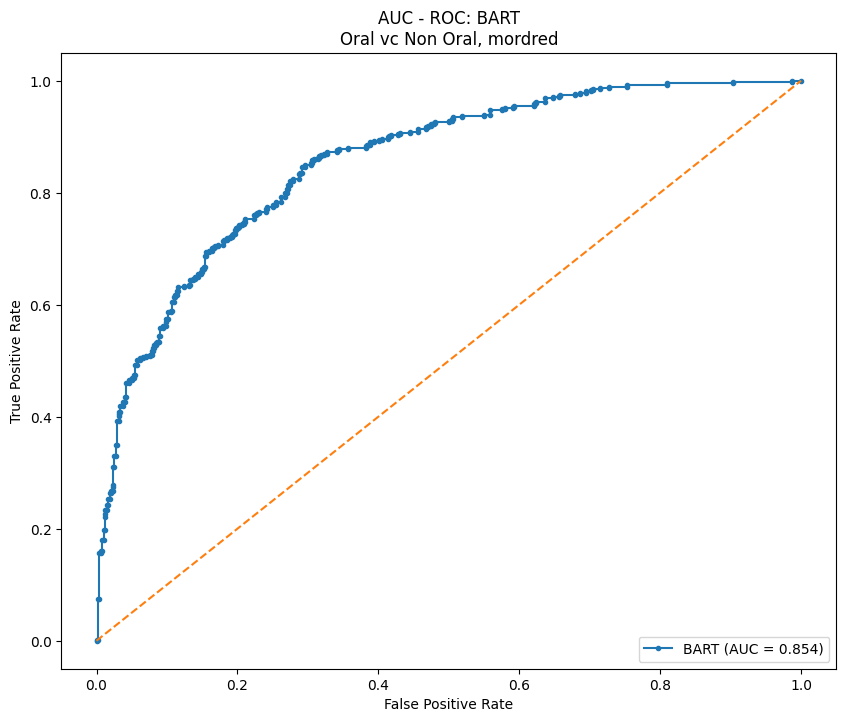

In [ ]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

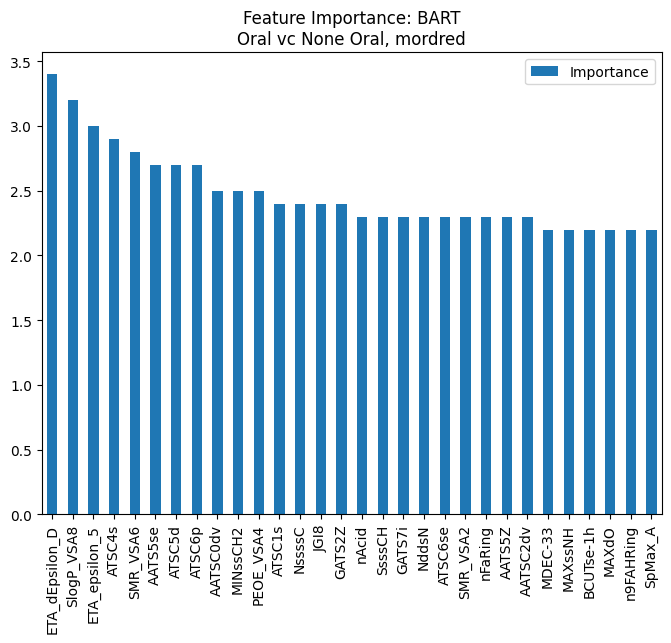

In [ ]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [ ]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
AETA_eta_RL,0.2
MATS5s,0.3
GATS3dv,0.4
AATSC7Z,0.4
MATS6s,0.4
...,...
SMR_VSA6,2.8
ATSC4s,2.9
ETA_epsilon_5,3.0
SlogP_VSA8,3.2


## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.171710,0.224684,0.828290,0.829857
1,Decision Tree,0.744382,0.257565,0.281646,0.742435,0.795125
2,Random Forest,0.500000,0.500000,0.500000,0.500000,0.500000
3,Gradiant Boosting,0.805155,0.002111,0.251055,0.997889,0.842386
4,BART,0.738150,0.207248,0.238397,0.792752,0.854408


In [ ]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [ ]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [ ]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [ ]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 10:38
Finished Grid Search for SVM: 13:12
Tempo de execução:  154.0 minutos


## Fitting Model

In [ ]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 0.8, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0021
Training AUC: 0.9979


## Make Prediction

In [ ]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.4852


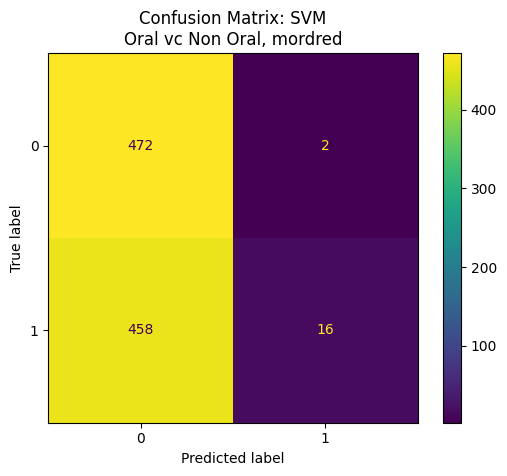

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

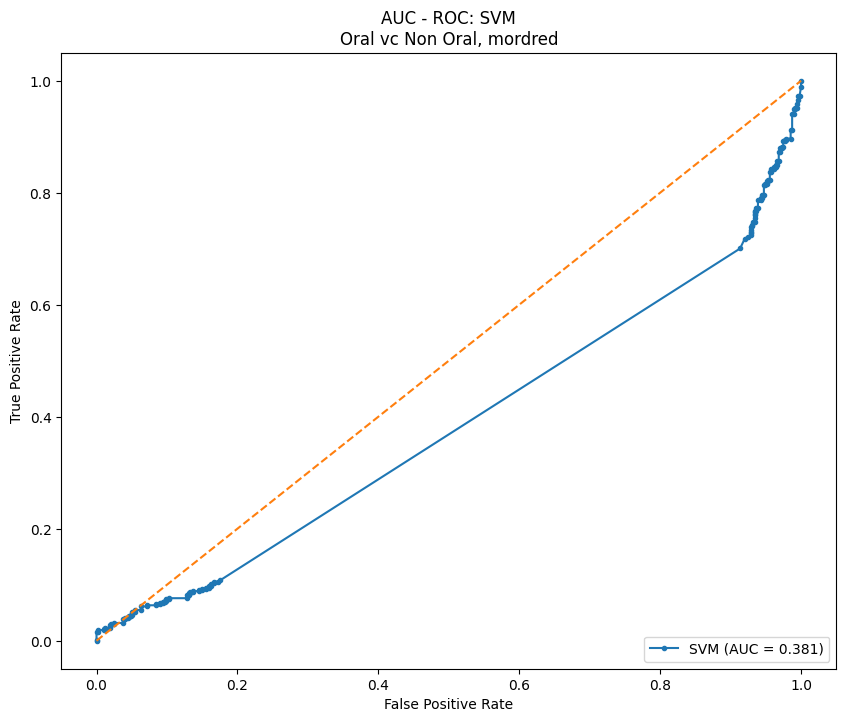

In [ ]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.171710,0.224684,0.828290,0.829857
1,Decision Tree,0.744382,0.257565,0.281646,0.742435,0.795125
2,Random Forest,0.500000,0.500000,0.500000,0.500000,0.500000
3,Gradiant Boosting,0.805155,0.002111,0.251055,0.997889,0.842386
4,BART,0.738150,0.207248,0.238397,0.792752,0.854408
5,SVM,0.595855,0.002111,0.485232,0.997889,0.381282


# Saving Final Datasets

In [ ]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [ ]:
session_info.show()